In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dt_apriltags import Detector
from sklearn.cluster import DBSCAN

In [100]:
img = cv2.imread("rov_pool.jpg")

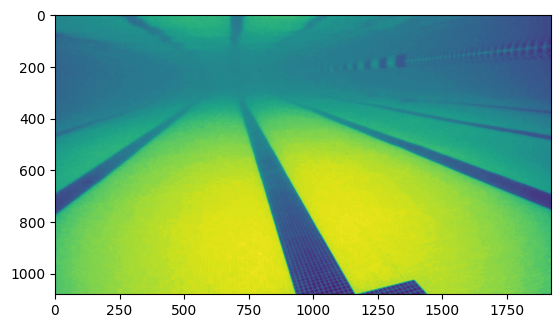

In [101]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
plt.imshow(gray)

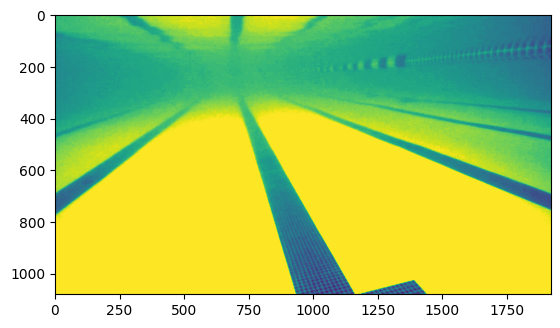

In [102]:
adjusted = cv2.convertScaleAbs(gray, alpha=2.5, beta=0)
plt.imshow(adjusted)

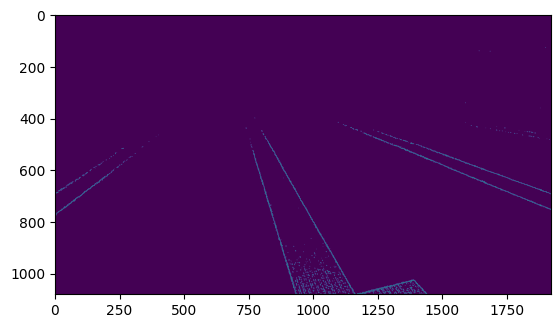

In [103]:
# edges = cv2.Canny(image=gray, threshold1=25, threshold2=175, apertureSize=3) # detect edges
edges = cv2.Canny(gray, 50, 50, apertureSize=3) # detect edges
plt.imshow(edges)

In [104]:
def find_slope(line):
    x1, y1, x2, y2 = line[0]
    denom = x2 - x1
    if denom == 0:
        return np.inf
    line_slope = (y2 - y1) / (x2 - x1)
    return line_slope
    
def merge_colinear_lines(lines):
    """
    Attempts to merge colinear lines.
    """
    slopes = [find_slope(line) for line in lines] # extract slopes of the lines
    slopes = np.array(slopes).reshape(-1, 1) # convert slopes to a 2d array

    # DBSCAN clustering to group colinear lines
    # `eps` is the maximum distance between two samples for them to be part of the same cluster
    # `min_samples` is the minimum number of samples for something to become its own cluster
    dbscan = DBSCAN(eps = 0.1, min_samples=2)
    labels = dbscan.fit_predict(slopes) # labels is a list of clusters, basically

    # Group lines based on the cluster labels
    grouped_lines = {}
    for idx, line in enumerate(lines):
        label = labels[idx]
        if label not in grouped_lines:
            grouped_lines[label] = []
        grouped_lines[label].append(line)

    
    # Calculate the average slope for each cluster
    merged_lines = []
    for label, cluster_lines in grouped_lines.items():
        average_slope = np.mean([find_slope(line) for line in cluster_lines])
        merged_lines.append((cluster_lines[0], average_slope))

    return merged_lines

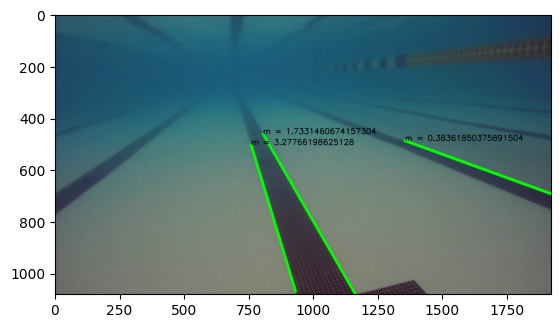

In [105]:
# plt.imshow(edges)
lines = cv2.HoughLinesP(
                edges,
                1,
                np.pi/180,
                100,
                minLineLength=500,
                maxLineGap=50
                ,
        ) # detect lines

lines = merge_colinear_lines(lines)

for line in lines:
    x1, y1, x2, y2 = line[0][0]
    line_slope = line[1]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 10)    
    cv2.putText(img, f"m = {line_slope}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [106]:
def detect_lanes(img, t1, t2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    edges = cv2.Canny(gray, t1, t2, apertureSize=3) # detect edges
    lines = cv2.HoughLinesP(
                    edges,
                    1,
                    np.pi/180,
                    100,
                    minLineLength=300,
                    maxLineGap=30,
            ) # detect lines
    
    lines = merge_colinear_lines(lines)

    for line in lines:
        x1, y1, x2, y2 = line[0][0]
        line_slope = line[1]
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 10)
        cv2.putText(img, f"m = {line_slope}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


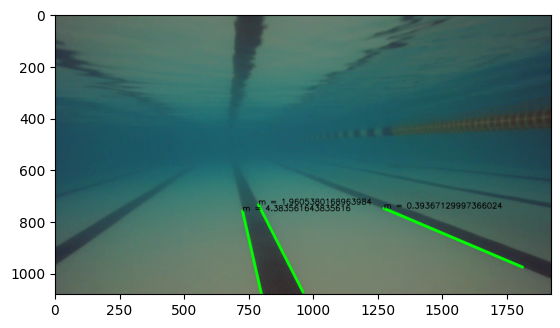

In [109]:
cap = cv2.VideoCapture('AUV_Vid.mkv')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

# plt.imshow(detect_lanes(cv2.imread("rov_pool.jpg"), 50, 50))
ret, frame = cap.read()
plt.imshow(detect_lanes(frame, 50, 50))
# while cap.isOpened():
    # ret, frame = cap.read()
    # plt.imshow(frame)
    # out.write(detect_lanes(frame, 50, 50))
    # plt.imshow(detect_lanes(frame))